In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd

class TrainDataset(Dataset):
    def __init__(self, csv_file, num_features):
        self.data = pd.read_csv(csv_file)
        self.num_features = num_features

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        #features = self.data.iloc[idx, 1:].values.astype(float)
        # Get the features from columns x1 to xN
        col_names = ["x" + str(i) for i in range(1, self.num_features + 1)]
        features = self.data[col_names].values.astype(float)
        feature_names = ["Deposit", "Harvest", "Lock", "Unlock", "Withdraw"]
        labels = self.data[feature_names].values.astype(float)
        return torch.tensor(features), torch.tensor(labels)

base_path = "expansión/"
num_features = 8

train_dataset = TrainDataset(base_path + "traindata.csv", num_features)
train_dataloader = DataLoader(train_dataset, batch_size=None, shuffle=False)

test_dataset = TrainDataset(base_path + "testdata.csv", num_features)
test_dataloader = DataLoader(test_dataset, batch_size=None, shuffle=False)

val_dataset = TrainDataset(base_path + "validationdata.csv", num_features)
val_dataloader = DataLoader(val_dataset, batch_size=None, shuffle=False)

In [2]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_func):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.activation_func = activation_func
        
        layers = []
        prev_size = input_size
        for size in hidden_sizes:
            layers.append(nn.Linear(prev_size, size))
            if activation_func != nn.Linear:
                layers.append(activation_func())
            prev_size = size
        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [3]:
hidden_size_configs = [4,5,6,7,8]
activation_func_configs = [nn.ReLU, nn.Tanh, nn.Sigmoid, nn.Linear]
learning_rate_configs = [0.2,0.3,0.4,0.5]
num_layers_configs = [1,2,3,4]

from itertools import product

all_configs = list(product(hidden_size_configs, activation_func_configs, 
                            learning_rate_configs, num_layers_configs))


In [4]:
def do_run(hidden_size, activation_func, learning_rate, num_layers):

    import wandb

    run_name = (f"{hidden_size}hs{activation_func.__name__}ac{learning_rate}lr"
                f"{num_layers}nl")

    run = wandb.init(project="encoded_predict", name=run_name, entity="jpossaz",
                config={
                    "hidden_size": hidden_size,
                    "activation_func": activation_func.__name__,
                    "learning_rate": learning_rate,
                    "num_layers": num_layers,
                    "num_features": num_features,
                    "base_path": base_path,
                    "train_dataset_class": train_dataset.__class__.__name__,
                    })

    input_size = num_features
    output_size = 5
    hidden_sizes = [hidden_size]
    activation_func = activation_func
    model = MLP(input_size, hidden_sizes, output_size, activation_func)
    # Convert to same dtype as the data
    model = model.double()

    epochs = 50

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):

        total_loss = torch.tensor(0.0)
        for x_train, y_train in train_dataloader:
            optimizer.zero_grad()
            output = model(x_train)
            total_loss += criterion(output, y_train.argmax(dim=1))

        total_loss /= len(train_dataloader)
        total_loss.backward()
        optimizer.step()

        with torch.no_grad():
            train_loss = 0
            for x_train, y_train in train_dataloader:
                output = model(x_train)
                train_loss += criterion(output, y_train.argmax(dim=1))
            train_loss /= len(train_dataloader)

            test_loss = 0
            for x_test, y_test in test_dataloader:
                output = model(x_test)
                test_loss += criterion(output, y_test.argmax(dim=1))
            test_loss /= len(test_dataloader)

            # Log metrics to W&B
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "test_loss": test_loss
            })
        
    # Close the run
    wandb.finish()
    return model

In [5]:
"""

from joblib import Parallel, delayed

tasks = [
    delayed(do_run)(hidden_size, activation_func, learning_rate, num_layers)
    for hidden_size, activation_func, learning_rate, num_layers in all_configs
]

# Parallel with very verbose output 
Parallel(n_jobs=8, verbose=10)(tasks)
"""

'\n\nfrom joblib import Parallel, delayed\n\ntasks = [\n    delayed(do_run)(hidden_size, activation_func, learning_rate, num_layers)\n    for hidden_size, activation_func, learning_rate, num_layers in all_configs\n]\n\n# Parallel with very verbose output \nParallel(n_jobs=8, verbose=10)(tasks)\n'

In [6]:
inference_model = do_run(8, nn.Sigmoid, 0.5, 1)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jpossaz. Use `wandb login --relogin` to force relogin


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_loss,▇█▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▇█▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
test_loss,0.24108
train_loss,0.24613


In [7]:
x_vals = []
y_vals = []
y_real = []

# Run inference on the validation set
for x_val, y_val in val_dataloader:
    output = inference_model(x_val)
    x_vals.append(x_val)
    y_vals.append(output.argmax(dim=1))
    y_real.append(y_val.argmax(dim=1))

In [8]:
# Compute accuracy
correct = 0
total = 0
for i in range(len(y_vals)):
    for j in range(len(y_vals[i])):
        if y_vals[i][j] == y_real[i][j]:
            correct += 1
        total += 1

print(f"Accuracy: {correct/total}")

Accuracy: 0.9045543847115556


In [9]:
input()

''

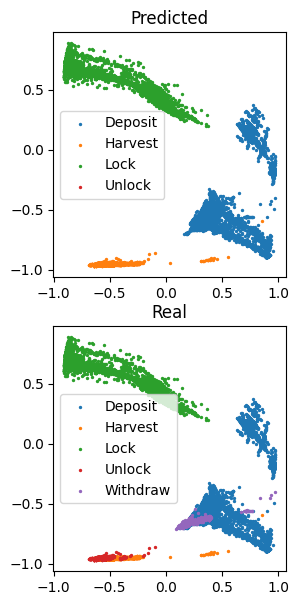

In [10]:
# Plot the x and y values, using the predicted y values as the color and icon
import matplotlib.pyplot as plt
import numpy as np

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(3, 7))

feature_names = ["Deposit", "Harvest", "Lock", "Unlock", "Withdraw"]

for i in range(len(np.unique(y_vals[0]))):
    name = feature_names[i]
    ax[0].scatter(x_vals[0][y_vals[0] == i,0], x_vals[0][y_vals[0] == i,1], s=2, label=name)

ax[0].set_title("Predicted")
ax[0].legend()

for i in range(len(np.unique(y_real[0]))):
    name = feature_names[i]
    ax[1].scatter(x_vals[0][y_real[0] == i,0], x_vals[0][y_real[0] == i,1], s=2, label=name)

ax[1].set_title("Real")
ax[1].legend()

plt.show()